In [1]:
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import yfinance as yf
import glob

from striprtf.striprtf import rtf_to_text
from transformers import pipeline
from nltk.sentiment import SentimentIntensityAnalyzer

/Users/hamzakhamissa/opt/anaconda3/envs/DS3000env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch, transformers
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)


torch: 2.2.2
transformers: 4.57.6


In [3]:
nltk.download("vader_lexicon", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)

True

In [4]:
SIA = SentimentIntensityAnalyzer()

In [5]:
# If error on nltk uncomment
## %pip install -q nltk striprtf pandas
## %pip install -q transformers torch yfinance nltk striprtf pandas matplotlib


In [6]:
rtf_files = ["../data/Meta_1Month.rtf"]
rtf_files

['../data/Meta_1Month.rtf']

In [7]:
def load_rtf_file(rtf_path: str) -> str:
    with open(rtf_path, "r", encoding="utf-8", errors="ignore") as f:
        raw_rtf = f.read()
    return rtf_to_text(raw_rtf)

In [8]:
def split_into_articles(text: str) -> list[str]:
    chunks = re.split(
        r"\n\s*Document\s+[A-Z0-9]+\s*\n",
        text,
        flags=re.IGNORECASE
    )

    articles = []
    for chunk in chunks:
        chunk = chunk.strip()

        if (
            "Factiva RTF Display Format" in chunk
            or "Table of Contents" in chunk
            or chunk.startswith("•")
        ):
            continue

        if len(chunk) < 200:
            continue

        lines = [l.strip() for l in chunk.splitlines() if l.strip()]
        if lines:
            bullet_ratio = sum(1 for l in lines if l.startswith("•")) / len(lines)
            if bullet_ratio > 0.7:
                continue

        articles.append(chunk)

    return articles


In [9]:
def parse_article(chunk: str) -> dict | None:
    lines = [l.strip() for l in chunk.splitlines() if l.strip()]
    if not lines:
        return None

    headline = lines[0]

    date = None
    source = None
    date_idx = None
    word_count = None

    for i, line in enumerate(lines[:30]):
        date_match = re.search(r"\d{1,2}\s+[A-Za-z]+\s+\d{4}", line)
        if date_match:
            date = line
            date_idx = i

            if i > 0 and re.search(r"\d+[,\d]*\s+words?", lines[i - 1], flags=re.IGNORECASE):
                word_count = lines[i - 1]

            for j in range(i + 1, min(i + 6, len(lines))):
                potential_source = lines[j]
                if (
                    not re.match(r"^\d+:\d+", potential_source)
                    and not re.match(r"^[A-Z]{2,6}$", potential_source)
                    and len(potential_source) > 3
                ):
                    source = potential_source
                    break
            break

    body_start = 1
    if date_idx is not None and date_idx > 1:
        body_start = min(date_idx + 4, len(lines))

    body = "\n".join(lines[body_start:])

    return {
        "headline": headline,
        "date": date,
        "source": source,
        "word_count": word_count,
        "raw_text": body,
        "full_text": chunk,
    }


In [10]:
def clean_article_text(text: str) -> str:
    text = re.sub(r"\b\d{1,2}:?\d{2,4}\s*ET\s*-?\s*", "", text)
    text = re.sub(r"--\s*\d+(st|nd|rd|th)?\s*Update", "", text, flags=re.IGNORECASE)
    text = re.sub(r"--\s*Update", "", text, flags=re.IGNORECASE)
    text = re.sub(r"Write to.*?@.*?\.(com|org|net)", "", text, flags=re.IGNORECASE)
    text = re.sub(r"Copyright\s*©?\s*\d+.*?(Inc\.|Company)", "", text, flags=re.IGNORECASE)

    text = re.sub(r"Document\s+[A-Z0-9]+", "", text, flags=re.IGNORECASE)
    text = re.sub(r"Dow Jones Institutional News", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\bDJDN\b", "", text, flags=re.IGNORECASE)

    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"English\s*,?\s*Inc\.\s*All Rights Reserved\.", "", text, flags=re.IGNORECASE)
    text = re.sub(r"All Rights Reserved\.", "", text, flags=re.IGNORECASE)
    return text.strip()

In [11]:
def analyze_sentiment_vader(text: str, max_chars: int = 5000) -> dict:
    text_sample = text[:max_chars]
    scores = SIA.polarity_scores(text_sample)

    return {
        "vader_compound": scores["compound"],
        "vader_pos": scores["pos"],
        "vader_neg": scores["neg"],
        "vader_neu": scores["neu"],
    }

In [12]:
def process_rtf_file(rtf_path: str, ticker: str | None = None) -> pd.DataFrame:
    text = load_rtf_file(rtf_path)
    articles = split_into_articles(text)

    rows = []
    for article in articles:
        parsed = parse_article(article)
        if parsed:
            rows.append(parsed)

    df = pd.DataFrame(rows)
    if df.empty:
        cols = ["headline", "date", "source", "word_count", "clean_text", "vader_compound", "vader_pos", "vader_neg", "vader_neu"]
        if ticker:
            cols = ["ticker"] + cols
        return pd.DataFrame(columns=cols)

    df["clean_text"] = df["raw_text"].apply(clean_article_text)

    sentiment_scores = df["clean_text"].apply(analyze_sentiment_vader)
    sentiment_df = pd.DataFrame(sentiment_scores.tolist())

    result = pd.concat([df, sentiment_df], axis=1)

    if ticker:
        result["ticker"] = ticker

    cols = [
        "headline",
        "date",
        "source",
        "word_count",
        "vader_compound",
        "vader_pos",
        "vader_neg",
        "vader_neu",
        "clean_text",
    ]
    if ticker:
        cols = ["ticker"] + cols

    cols = [c for c in cols if c in result.columns]
    return result[cols]

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_id = "tabularisai/ModernFinBERT"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, use_safetensors=True)

finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use mps:0


In [14]:
# Helper
def finbert_to_signed_score(label: str, confidence: float) -> float:
    label = label.lower()
    if label == "positive":
        return confidence
    if label == "negative":
        return -confidence
    return 0.0

In [15]:
# Article-level
def finbert_article_sentiment(text: str, max_chars: int = 3500):
    text = text[:max_chars]
    out = finbert(text)[0]
    signed = finbert_to_signed_score(out["label"], out["score"])
    return out["label"], out["score"], signed

In [16]:
# Sentence level
def split_sentences(text: str) -> list[str]:
    sents = nltk.sent_tokenize(text)
    sents = [s.strip() for s in sents if len(s.strip()) >= 30]
    return sents


def finbert_sentence_sentiment(text: str, max_sentences: int = 25):
    sents = split_sentences(text)[:max_sentences]
    if not sents:
        return 0.0, 0, 0

    outputs = finbert(sents)
    signed_scores = [finbert_to_signed_score(o["label"], o["score"]) for o in outputs]

    avg_score = float(np.mean(signed_scores))
    pos_count = sum(1 for o in outputs if o["label"].lower() == "positive")
    neg_count = sum(1 for o in outputs if o["label"].lower() == "negative")

    return avg_score, pos_count, neg_count

In [17]:
all_dfs = []

for path in rtf_files:
    ticker = path.split("/")[-1].replace(".RTF", "").replace(".rtf", "")
    df = process_rtf_file(path, ticker=ticker)
    all_dfs.append(df)

combined = pd.concat(all_dfs, ignore_index=True)
combined.to_csv("../db/all_stocks_sentiment.csv", index=False)
combined.head()

,ticker,headline,date,source,word_count,vader_compound,vader_pos,vader_neg,vader_neu,clean_text
0,Meta_1Month,Tech,23 May 2018,WSJ Pro Cybersecurity,"1,209 words",-0.9812,0.060,0.093,0.847,"English , Inc. BRUSSELS—Mark Zuckerberg apolog..."
1,Meta_1Month,Glen Herrick of Meta Financial in second quart...,21 May 2018,People in Business,"3,055 words",0.9984,0.128,0.006,0.865,Copyright 2018. News Bites Pty Ltd. Glen Herri...
2,Meta_1Month,Meta Financial director Frederick V. Moore sel...,Meta Financial director Frederick V. Moore sel...,"2,882 words",None,0.9976,0.113,0.008,0.879,"2,882 words 23 May 2018 People in Business NBP..."
3,Meta_1Month,Meta Financial director Douglas J. Hajek sells...,Meta Financial director Douglas J. Hajek sells...,"3,065 words",None,0.9981,0.124,0.007,0.869,"3,065 words 5 May 2018 People in Business NBPP..."
4,Meta_1Month,Meta Financial director Frederick V. Moore sel...,Meta Financial director Frederick V. Moore sel...,"3,139 words",None,0.9966,0.099,0.008,0.893,"3,139 words 4 May 2018 People in Business NBPP..."


In [18]:
def load_rtf_file(rtf_path: str) -> str:
    with open(rtf_path, "r", encoding="utf-8", errors="ignore") as f:
        raw_rtf = f.read()
    return rtf_to_text(raw_rtf)


In [19]:
finbert("Apple shares fell afterweak guidance")

[{'label': 'bearish', 'score': 0.9956895709037781}]

In [20]:
finbert("Should i buy apple stock")

[{'label': 'bullish', 'score': 0.5161255598068237}]

In [21]:
def finbert_score(text, max_chars=3500):
    text = text[:max_chars]
    out = finbert(text)[0]

    label = out["label"].lower()
    conf = float(out["score"])

    if label in ["positive", "bullish"]:
        signed = conf
    elif label in ["negative", "bearish"]:
        signed = -conf
    else:
        signed = 0.0

    return {
        "finbert_label": out["label"],
        "finbert_conf": conf,
        "finbert_signed": signed
    }


In [22]:
finbert_df = df["clean_text"].apply(lambda t: pd.Series(finbert_score(t)))
df = pd.concat([df, finbert_df], axis=1)

df[["headline", "date", "finbert_label", "finbert_signed"]].head(10)


,headline,date,finbert_label,finbert_signed
0,Tech,23 May 2018,neutral,0.0
1,Glen Herrick of Meta Financial in second quart...,21 May 2018,neutral,0.0
2,Meta Financial director Frederick V. Moore sel...,Meta Financial director Frederick V. Moore sel...,neutral,0.0
3,Meta Financial director Douglas J. Hajek sells...,Meta Financial director Douglas J. Hajek sells...,neutral,0.0
4,Meta Financial director Frederick V. Moore sel...,Meta Financial director Frederick V. Moore sel...,neutral,0.0
5,Business,11 May 2018,neutral,0.0
6,International Business Machines Corporation; P...,25 May 2018,neutral,0.0
7,"Patent Application; ""Method and System for Man...",8 May 2018,neutral,0.0
8,Business,16 May 2018,neutral,0.0
9,Illinois firm buys startup backed by Mark Cuban,3 May 2018,neutral,0.0


In [23]:
df = df.loc[:, ~df.columns.duplicated(keep="last")]

In [24]:
df["vader_compound"].describe()

count    50.000000
mean      0.474760
std       0.791417
min      -0.996400
25%       0.021900
50%       0.976000
75%       0.996475
max       0.999500
Name: vader_compound, dtype: float64

In [25]:
df["finbert_signed"].describe()
df["finbert_label"].value_counts()

finbert_label
neutral    45
bearish     3
bullish     2
Name: count, dtype: int64

In [26]:
df["finbert_signed"].describe()

count    50.000000
mean     -0.013659
std       0.238701
min      -0.865538
25%       0.000000
50%       0.000000
75%       0.000000
max       0.907706
Name: finbert_signed, dtype: float64

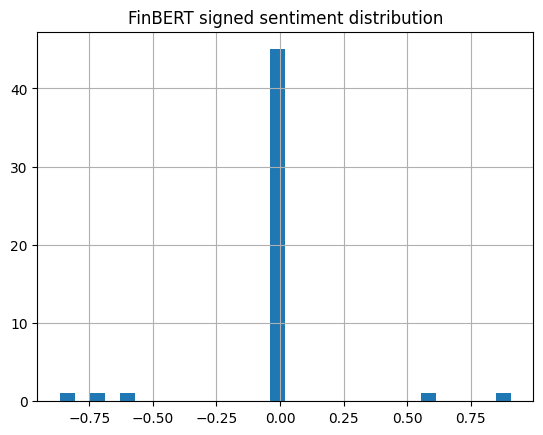

In [27]:
df["finbert_signed"].hist(bins=30)
plt.title("FinBERT signed sentiment distribution")
plt.show()

In [28]:
def finbert_sentence_avg(text, max_sentences=25):
    sentences = nltk.sent_tokenize(text)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 30][:max_sentences]

    if not sentences:
        return 0.0

    outs = finbert(sentences)

    signed_scores = []
    for o in outs:
        label = o["label"].lower()
        score = float(o["score"])

        if label in ["bullish", "positive"]:
            signed_scores.append(score)
        elif label in ["bearish", "negative"]:
            signed_scores.append(-score)
        else:
            signed_scores.append(0.0)

    return float(np.mean(signed_scores))

In [29]:
df["finbert_sent_avg"] = df["clean_text"].apply(finbert_sentence_avg)
df["finbert_sent_avg"].describe()


count    50.000000
mean     -0.070799
std       0.134054
min      -0.361687
25%      -0.131018
50%      -0.056053
75%       0.014914
max       0.316423
Name: finbert_sent_avg, dtype: float64

In [30]:
df["date_dt"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date_dt"])
df["date_only"] = df["date_dt"].dt.date

daily = df.groupby(["ticker", "date_only"]).agg(
    finbert_daily=("finbert_sent_avg", "mean"),
    vader_daily=("vader_compound", "mean"),
    num_articles=("headline", "count")
).reset_index()

daily.head()


,ticker,date_only,finbert_daily,vader_daily,num_articles
0,Meta_1Month,2018-05-01,-0.085755,0.816650,6
1,Meta_1Month,2018-05-02,-0.107793,0.993400,1
2,Meta_1Month,2018-05-03,-0.096141,0.862175,4
3,Meta_1Month,2018-05-06,-0.037826,0.983100,1
4,Meta_1Month,2018-05-08,-0.021778,0.855600,1


In [31]:
df["ticker_norm"] = df["ticker"].astype(str).str.upper()

ticker_map = {
    "META_FACEBOOK": "META",
    "FACEBOOK": "META",
    "APPLE": "AAPL",
    "MICROSOFT": "MSFT",
    "AMAZON": "AMZN",
    "TESLA": "TSLA",
    "NVIDIA": "NVDA",
}

df["ticker_yf"] = df["ticker_norm"].map(ticker_map).fillna(df["ticker_norm"])
df[["ticker", "ticker_norm", "ticker_yf"]].head(5)


,ticker,ticker_norm,ticker_yf
0,Meta_1Month,META_1MONTH,META_1MONTH
1,Meta_1Month,META_1MONTH,META_1MONTH
5,Meta_1Month,META_1MONTH,META_1MONTH
6,Meta_1Month,META_1MONTH,META_1MONTH
7,Meta_1Month,META_1MONTH,META_1MONTH


In [35]:
ticker_yf = df["ticker_yf"].iloc[0]
ticker_yf = str(ticker_yf).split("_")[0]

sub = daily[daily["ticker"] == ticker_raw].copy()

start = pd.to_datetime(sub["date_only"].min()).strftime("%Y-%m-%d")
end = (pd.to_datetime(sub["date_only"].max()) + pd.Timedelta(days=5)).strftime("%Y-%m-%d")

prices = yf.download(ticker_yf, start=start, end=end, progress=False)

# Flatten MultiIndex columns if they exist
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = prices.columns.get_level_values(0)

prices = prices.reset_index()

if prices.empty:
    raise ValueError(f"yfinance returned no data for ticker: {ticker_yf}")

prices["date_only"] = prices["Date"].dt.date
prices["ret_1d"] = prices["Close"].pct_change()
prices["ret_next_1d"] = prices["ret_1d"].shift(-1)

merged = sub.merge(
    prices[["date_only", "ret_1d", "ret_next_1d"]],
    on="date_only",
    how="inner"
).dropna()

merged.head()


,ticker,date_only,finbert_daily,vader_daily,num_articles,ret_1d,ret_next_1d
1,Meta_1Month,2018-05-02,-0.107793,0.993400,1,0.012711,-0.011643
2,Meta_1Month,2018-05-03,-0.096141,0.862175,4,-0.011643,0.014883
3,Meta_1Month,2018-05-08,-0.021778,0.855600,1,0.005338,0.020903
4,Meta_1Month,2018-05-09,0.316423,0.999500,1,0.020903,0.015712
5,Meta_1Month,2018-05-10,-0.082883,0.906550,2,0.015712,0.007869


In [36]:
print("FinBERT vs same-day:", merged["finbert_daily"].corr(merged["ret_1d"]))
print("FinBERT vs next-day:", merged["finbert_daily"].corr(merged["ret_next_1d"]))
print("VADER  vs same-day:", merged["vader_daily"].corr(merged["ret_1d"]))
print("VADER  vs next-day:", merged["vader_daily"].corr(merged["ret_next_1d"]))


FinBERT vs same-day: 0.5674566067905938
FinBERT vs next-day: -0.018929688698855793
VADER  vs same-day: 0.31931085789634345
VADER  vs next-day: -0.010418101154356499


In [37]:
def finbert_sentence_weighted_avg(text, max_sentences=35):
    sents = nltk.sent_tokenize(text)
    sents = [s.strip() for s in sents if len(s.strip()) > 30][:max_sentences]
    if not sents:
        return 0.0

    outs = finbert(sents)

    signed_scores = []
    weights = []

    for o in outs:
        label = o["label"].lower()
        conf = float(o["score"])

        if label in ["bullish", "positive"]:
            signed_scores.append(conf)
        elif label in ["bearish", "negative"]:
            signed_scores.append(-conf)
        else:
            signed_scores.append(0.0)

        weights.append(conf)  # weight by confidence

    signed_scores = np.array(signed_scores)
    weights = np.array(weights)

    if weights.sum() == 0:
        return float(signed_scores.mean())

    return float((signed_scores * weights).sum() / weights.sum())


In [38]:
df["finbert_sent_wavg"] = df["clean_text"].apply(finbert_sentence_weighted_avg)


In [39]:
df["is_bull"] = df["finbert_label"].str.lower().isin(["bullish", "positive"]).astype(int)
df["is_bear"] = df["finbert_label"].str.lower().isin(["bearish", "negative"]).astype(int)

daily = df.groupby(["ticker", "date_only"]).agg(
    fin_mean=("finbert_sent_wavg", "mean"),
    fin_abs=("finbert_sent_wavg", lambda x: float(np.mean(np.abs(x)))),
    bull_pct=("is_bull", "mean"),
    bear_pct=("is_bear", "mean"),
    n=("headline", "count")
).reset_index()

daily["imbalance"] = daily["bull_pct"] - daily["bear_pct"]
daily.head()


,ticker,date_only,fin_mean,fin_abs,bull_pct,bear_pct,n,imbalance
0,Meta_1Month,2018-05-01,-0.083539,0.091653,0.0,0.0,6,0.0
1,Meta_1Month,2018-05-02,-0.011372,0.011372,1.0,0.0,1,1.0
2,Meta_1Month,2018-05-03,-0.117794,0.144437,0.0,0.0,4,0.0
3,Meta_1Month,2018-05-06,-0.028126,0.028126,0.0,0.0,1,0.0
4,Meta_1Month,2018-05-08,0.004514,0.004514,0.0,0.0,1,0.0


In [40]:
BAD_HEADLINE = re.compile(
    r"(today's markets|a-hed|morning|market wrap|digest|briefing|week ahead|what we're watching|recap|roundup)",
    re.IGNORECASE
)

df = df[~df["headline"].fillna("").str.contains(BAD_HEADLINE)].copy()


/var/folders/k6/ymp_77h10_j4z_4d_26n07700000gn/T/ipykernel_99664/860361405.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df["headline"].fillna("").str.contains(BAD_HEADLINE)].copy()


In [41]:
df = df[df["clean_text"].str.len() > 300].copy()


In [42]:
df["date_dt"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df = df.dropna(subset=["date_dt"])
df["date_only"] = df["date_dt"].dt.date


In [44]:
print(merged.columns.tolist())


['ticker', 'date_only', 'finbert_daily', 'vader_daily', 'num_articles', 'ret_1d', 'ret_next_1d']


In [45]:
merged["pred_dir"] = (merged["finbert_daily"] > 0).astype(int)
merged["true_dir"] = (merged["ret_next_1d"] > 0).astype(int)

acc = (merged["pred_dir"] == merged["true_dir"]).mean()
print("Directional accuracy (FinBERT):", acc)


Directional accuracy (FinBERT): 0.4117647058823529


In [46]:
merged["pred_dir"] = (merged["vader_daily"] > 0).astype(int)
merged["true_dir"] = (merged["ret_next_1d"] > 0).astype(int)

acc = (merged["pred_dir"] == merged["true_dir"]).mean()
print("Directional accuracy (VADER):", acc)


Directional accuracy (VADER): 0.5882352941176471


In [47]:
merged["mean_sent"] = merged[["finbert_daily", "vader_daily"]].mean(axis=1)

merged["pred_dir"] = (merged["mean_sent"] > 0).astype(int)
merged["true_dir"] = (merged["ret_next_1d"] > 0).astype(int)

acc = (merged["pred_dir"] == merged["true_dir"]).mean()
print("Directional accuracy (Mean):", acc)


Directional accuracy (Mean): 0.6470588235294118


In [48]:
df["finbert_sent_wavg"] = df["clean_text"].apply(finbert_sentence_weighted_avg)

df["is_bull"] = df["finbert_label"].str.lower().isin(["bullish", "positive"]).astype(int)
df["is_bear"] = df["finbert_label"].str.lower().isin(["bearish", "negative"]).astype(int)

df["date_dt"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date_dt"])
df["date_only"] = df["date_dt"].dt.date

daily = df.groupby(["ticker", "date_only"]).agg(
    fin_mean=("finbert_sent_wavg", "mean"),
    fin_abs=("finbert_sent_wavg", lambda x: float(np.mean(np.abs(x)))),
    bull_pct=("is_bull", "mean"),
    bear_pct=("is_bear", "mean"),
    num_articles=("headline", "count")
).reset_index()

daily["imbalance"] = daily["bull_pct"] - daily["bear_pct"]
daily.head()


,ticker,date_only,fin_mean,fin_abs,bull_pct,bear_pct,num_articles,imbalance
0,Meta_1Month,2018-05-01,-0.083539,0.091653,0.0,0.0,6,0.0
1,Meta_1Month,2018-05-02,-0.011372,0.011372,1.0,0.0,1,1.0
2,Meta_1Month,2018-05-03,-0.117794,0.144437,0.0,0.0,4,0.0
3,Meta_1Month,2018-05-06,-0.028126,0.028126,0.0,0.0,1,0.0
4,Meta_1Month,2018-05-08,0.004514,0.004514,0.0,0.0,1,0.0


In [50]:
baseline_acc = (merged["ret_next_1d"] > 0).mean()
print("Baseline (always predict UP) accuracy:", baseline_acc)


Baseline (always predict UP) accuracy: 0.5882352941176471
